Christopher Rudolph - 45241805 - MQ University 

**Note** I realised moment before finalising the notebook that there was a 'voucher_claim_year' column in the voucher DF. This could have changed my results if I started with this. Instead I will submit the notebook without this included in the work. The vouchers across the 3 years in this column have been merged. 

# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


## Index Definition

From here https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/2033.0.55.001~2016~Main%20Features~IRSAD~20

4 major indexes for every LGA. 

**IRSAD: index of relative socio economic advantage and disadvantage.**
- summarises information about the economic and social conditions of people and households within an area. Includes both relative advantage and disadvantage. 
- low score = greater disadvatange, lack of advantage in general. 
- low scores = many households with low incomes, many people in unskilled occupations. OR few households with high incomes. Few people in skilled occupations. 

**IEO: Index of education and occupation.**
- reflects the educational and occupational level of communities. 
- Education variables in this index show either the level of qualification achieved or wheteher further education is being undertaken. 
- Low score = relatively lower education and occupation status. 
- low score = many people without qualifications or many people in low skilled occuaptions or unemployed. AND few people with high level of qualification or highly skilled occupation. 

**IER: Index of economic resources.**
- focus' on the financial aspects of relative socio-economic advantage and disadvantage. Summarises variables related to income and wealth. 
- low score = relative lack to economic resources in general. 
- low score = many households with low income, or many paying low rent. AND few households with high income, or few owned homes. 

**IRSD: The index of relative socio economic disadvantage.**
- range of information about the economic and social conditions of people and households. 
- low score = relatively greater disadvantage in general. 
- low sore= many households with low income, people with no qualification OR many people in low skill occupations. 

**Local Government Areas - 2011** 
- Cities (C)
- Rural Cities (RC)
- Municipalities/Municipal Councils (M)
- District Councils (DC)
- Regional Councils (RegC)
- Towns (T)
- Aboriginal Councils (AC)

# setting up the DFs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

C:\Users\Rudol\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


In [4]:
seifa[seifa['LGA'] == 'ONKAPARINGA']

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
1392,45340,Onkaparinga (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,975,ONKAPARINGA
1393,45340,Onkaparinga (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,672,ONKAPARINGA
1394,45340,Onkaparinga (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1152,ONKAPARINGA
1395,45340,Onkaparinga (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,159517,ONKAPARINGA
3648,45340,Onkaparinga (C),IRSD,Index of Relative Socio-economic Disadvantage,SCORE,Score,993,ONKAPARINGA
3649,45340,Onkaparinga (C),IRSD,Index of Relative Socio-economic Disadvantage,MINS,Minimum score for SA1s in area,637,ONKAPARINGA
3650,45340,Onkaparinga (C),IRSD,Index of Relative Socio-economic Disadvantage,MAXS,Maximum score for SA1s in area,1141,ONKAPARINGA
3651,45340,Onkaparinga (C),IRSD,Index of Relative Socio-economic Disadvantage,URP,Usual resident population,159517,ONKAPARINGA
5904,45340,Onkaparinga (C),IER,Index of Economic Resources,SCORE,Score,996,ONKAPARINGA
5905,45340,Onkaparinga (C),IER,Index of Economic Resources,MINS,Minimum score for SA1s in area,674,ONKAPARINGA


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [5]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD
LGA,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0
ALBANY,999.0,999.0,977.0,987.0
ALBURY,964.0,964.0,967.0,979.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0


In [6]:
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_pop.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD
LGA,,,,
ADELAIDE,19606.0,19606.0,19606.0,19606.0
ADELAIDE HILLS,38601.0,38601.0,38601.0,38601.0
ALBANY,33614.0,33614.0,33614.0,33614.0
ALBURY,47851.0,47851.0,47851.0,47851.0
ALEXANDRINA,23693.0,23693.0,23693.0,23693.0


In [7]:
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [8]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [9]:
set(sa_vouchers_scores['Voucher_Claim_Year'])

{2015, 2016, 2017}

We can use the `.describe()` function to get a general idea of what the dataframe looks like

In [10]:
sa_vouchers_scores.describe()

,Participant_ID,Voucher_Value,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
count,1.275260e+05,127526.000000,127526.000000,118066.000000,118066.000000,118066.000000,118066.000000,118066.000000
mean,1.063764e+06,49.663951,2015.915100,981.049942,981.049942,971.090416,981.756314,68014.296046
std,3.681374e+04,2.700970,0.765087,44.454505,44.454505,56.889280,55.538098,50470.140017
min,1.000002e+06,5.000000,2015.000000,870.000000,870.000000,808.000000,798.000000,871.000000
25%,1.031883e+06,50.000000,2015.000000,955.000000,955.000000,927.000000,937.000000,22070.000000
50%,1.063764e+06,50.000000,2016.000000,974.000000,974.000000,973.000000,987.000000,62912.000000
75%,1.095646e+06,50.000000,2017.000000,1013.000000,1013.000000,997.000000,1018.000000,104922.000000
max,1.127526e+06,50.000000,2017.000000,1083.000000,1083.000000,1090.000000,1096.000000,159517.000000


Removing any uppercase words for ease of referencing the DF.

help from https://www.codegrepper.com/code-examples/python/convert+columns+to+lowercase+pandas

In [11]:
LGA_scores.index = LGA_scores.index.str.lower()

sa_vouchers.columns = sa_vouchers.columns.str.lower()

sa_vouchers_scores.columns = sa_vouchers_scores.columns.str.lower()

seifa.columns = seifa.columns.str.lower()

sa_vouchers.columns = sa_vouchers.columns.str.lower()

LGA_scores.columns = LGA_scores.columns.str.lower()

We know each row means a voucher has been claimed. 

Start off by checking how many unique LGAs there are. Then we can count how many times the LGA occurs. 

In [12]:
len(set(sa_vouchers_scores['participant_lga']))

69

It's quite difficult to use this type of dataframe due to the multi index. We can use `.pivot()` instead to make it more clear. 

Used help from the textbook for this part. Page 24, section 2.6.8



In [13]:
group = (sa_vouchers_scores.groupby(['participant_lga','voucher_sport']).count()).copy(deep=True)

In [14]:
group.head()

participant_id  participant_suburb  \
participant_lga voucher_sport                                          
ADELAIDE        Athletics                     16                  16   
                Australian Rules             130                 130   
                Baseball                       1                   1   
                Basketball                     4                   4   
                Calisthenics                   1                   1   

                                  club_previous_member  \
participant_lga voucher_sport                            
ADELAIDE        Athletics                           16   
                Australian Rules                   130   
                Baseball                             1   
                Basketball                           4   
                Calisthenics                         1   

                                  participant_atsi_indicator  \
participant_lga voucher_sport                                  
ADELAIDE        Athletics                                 16   
                Australian Rules                         130   
                Baseball                                   1   
                Basketball                                 4   
                Calisthenics                               1   

                                  participant_cald_indicator  participant_sex  \
participant_lga voucher_sport                                                   
ADELAIDE        Athletics                                 16               16   
                Australian Rules                         130              130   
                Baseball                                   1                1   
                Basketball                                 4                4   
                Calisthenics                               1                1   

                                  voucher_value  club_name  \
participant_lga voucher_sport                                
ADELAIDE        Athletics                    16         16   
                Australian Rules            130        130   
                Baseball                      1          1   
                Basketball                    4          4   
                Calisthenics                  1          1   

                                  participant_electorate  \
participant_lga voucher_sport                              
ADELAIDE        Athletics                             16   
                Australian Rules                     130   
                Baseball                               1   
                Basketball                             4   
                Calisthenics                           1   

                                  voucher_completion_date  voucher_claim_year  \
participant_lga voucher_sport                                                   
ADELAIDE        Athletics                              16                  16   
                Australian Rules                      128                 130   
                Baseball                                1                   1   
                Basketball                              4                   4   
                Calisthenics                            1                   1   

                                  ieo  ier  irsad  irsd  population  
participant_lga voucher_sport                                        
ADELAIDE        Athletics          16   16     16    16          16  
                Australian Rules  130  130    130   130         130  
                Baseball            1    1      1     1           1  
                Basketball          4    4      4     4           4  
                Calisthenics        1    1      1     1           1

keeping all rows and only keeping one column. All the columns represent the same number of counts, so we only need to keep one. 

In [15]:
saSports = pd.pivot_table(group, values = 'participant_id', index = 'participant_lga', columns = 'voucher_sport')

In [16]:
saSports.head()

voucher_sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
participant_lga,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,130.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,257.0,2.0,1.0,1.0,NaN,NaN
ADELAIDE PLAINS,NaN,3.0,485.0,NaN,NaN,3.0,15.0,NaN,23.0,3.0,...,NaN,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,NaN,204.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1196.0,3.0,NaN,6.0,341.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN


In [17]:
saSports = saSports.fillna(0)

Applying the pivot table has drastically aided in the dimensioniality of the DF, making it easier to explore the DF. I have also changed the NAN values to zero, making the assumption that the nan values represent no voucher redeemed. 

Changing the indices and columns to lower case for ease of referencing

In [18]:
saSports.index = saSports.index.str.lower()
saSports.columns = saSports.columns.str.lower()

# Data exploration

Please note, this section was created at the end as I realised I had not created one. I do not have enough time to contribute much to this. I wanted to see how the DF would differ if I incorporate the different voucher claim years. This could have affected the SEIFA score relationship seen in question 4. 

In [22]:
group2 = (sa_vouchers_scores.groupby(['participant_lga','voucher_claim_year']).count()).copy(deep=True)
group2.head()

participant_id  participant_suburb  \
participant_lga voucher_claim_year                                       
ADELAIDE        2015                            99                  99   
                2016                           136                 136   
                2017                            67                  67   
ADELAIDE HILLS  2015                          1814                1814   
                2016                          2111                2111   

                                    club_previous_member  \
participant_lga voucher_claim_year                         
ADELAIDE        2015                                  99   
                2016                                 136   
                2017                                  67   
ADELAIDE HILLS  2015                                1814   
                2016                                2111   

                                    participant_atsi_indicator  \
participant_lga voucher_claim_year                               
ADELAIDE        2015                                        99   
                2016                                       136   
                2017                                        67   
ADELAIDE HILLS  2015                                      1814   
                2016                                      2111   

                                    participant_cald_indicator  \
participant_lga voucher_claim_year                               
ADELAIDE        2015                                        99   
                2016                                       136   
                2017                                        67   
ADELAIDE HILLS  2015                                      1814   
                2016                                      2111   

                                    participant_sex  voucher_value  club_name  \
participant_lga voucher_claim_year                                              
ADELAIDE        2015                             99             99         99   
                2016                            136            136        136   
                2017                             67             67         67   
ADELAIDE HILLS  2015                           1814           1814       1814   
                2016                           2111           2111       2111   

                                    voucher_sport  participant_electorate  \
participant_lga voucher_claim_year                                          
ADELAIDE        2015                           99                      99   
                2016                          136                     136   
                2017                           67                      67   
ADELAIDE HILLS  2015                         1814                    1814   
                2016                         2111                    2111   

                                    voucher_completion_date   ieo   ier  \
participant_lga voucher_claim_year                                        
ADELAIDE        2015                                     99    99    99   
                2016                                    136   136   136   
                2017                                     61    67    67   
ADELAIDE HILLS  2015                                   1814  1814  1814   
                2016                                   2111  2111  2111   

                                    irsad  irsd  population  
participant_lga voucher_claim_year                           
ADELAIDE        2015                   99    99          99  
                2016                  136   136         136  
                2017                   67    67          67  
ADELAIDE HILLS  2015                 1814  1814        1814  
                2016                 2111  2111        2111

In [28]:
pivot2 = pd.pivot_table(group2, values = 'participant_id', index = 'participant_lga', columns = 'voucher_claim_year')
pivot2

voucher_claim_year,2015,2016,2017
participant_lga,,,
ADELAIDE,99.0,136.0,67.0
ADELAIDE HILLS,1814.0,2111.0,831.0
ADELAIDE PLAINS,284.0,353.0,262.0
ALEXANDRINA,1050.0,1225.0,704.0
BAROSSA,970.0,1136.0,768.0
...,...,...,...
WEST TORRENS,1024.0,1088.0,732.0
WHYALLA,870.0,922.0,696.0
WUDINNA,88.0,103.0,76.0


# Question 1

 Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

## Normalising with the total claims 

We want to find out the proportion of vouchers claimed per suburb. this will involve dividing the total vouchers claimed in the LGA by the total vouchers claimed in the state. 

Because the least popular sports don't have many claims, it would be justifiable to not inclue it in the rest of the analysis for this part. Plotting the least popular sports wouldn't yield much information. We can determine the least popular sports. 

When comparing LGAs, it would be better to normalise by each of their populations. Because comparing one LGA which might have a large population won't be a fair comparison. The other option would be to normalise the population of the LGA to the population of the entire state. Although The LGAs with the highest populations would saturate the data. 

If we don't know how the vouchers were distributed, it will be better to normalise with respect to the total vouchers claimed rather than by the population because there could be 2 vouchers per person. 

We want
- the total number of vouchers claimed for all LGAs combined. 
- how the total of vouchers claimed for a specific sport compares to the total claimed
- what does this tell us? 

We know the total number of vouchers clamed is the number of rows in sa_vouchers_scores, as each row represents a claimed voucher.

The total vouchers claimed for all sports:

In [18]:
claimDF = saSports.sum().to_frame(name='sum')

The proportion of vouchers claimed for each sport to the total vouchers claimed.

In [19]:
claimDF['proportion'] =claimDF['sum'] / claimDF.sum()[0]


In [20]:
claimDF.head()

,sum,proportion
voucher_sport,,
archery,34.0,0.000267
athletics,4518.0,0.035428
australian rules,47224.0,0.370309
bmx,157.0,0.001231
badminton,4.0,0.000031


checking the mean of the proportion alllows us to see an upper vs lower half of the sports claim rate

In [21]:
round(claimDF['proportion'].mean(), 2)

0.02

The mean claim rate for all the sports is 2%. This means there are alot of sports with a very low claim rate, and very few sports with a high claim rate. We can check how many sports are above and below the mean:

In [22]:
print(f'There are {len(claimDF[claimDF["proportion"] >claimDF["proportion"].mean()])} sports with claim rate above the mean of 2%')

There are 8 sports with claim rate above the mean of 2%


In [23]:
print(f'There are {len(claimDF[claimDF["proportion"]<claimDF["proportion"].mean()])} sports with claim rate above the mean of 2%')

There are 42 sports with claim rate above the mean of 2%


Determining the most popular and least popular sports

In [24]:
topSports = list(claimDF['proportion'].nlargest(5).index)

In [25]:
botSports = list(claimDF['proportion'].nsmallest(5).index)

Plotting the proportions of these sports

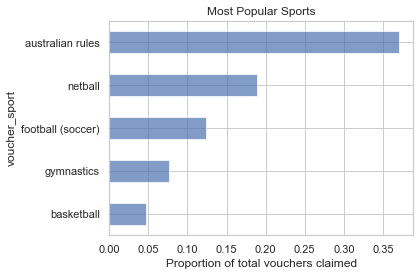

In [26]:
sns.set_theme(style="whitegrid")
fig, axes= plt.subplots(1,1)


claimDF['proportion'][topSports].sort_values().plot(kind='barh', style='b', alpha=0.7,
              title='Most Popular Sports')

plt.xlabel('Proportion of total vouchers claimed')
plt.tight_layout()
plt.show()

Least popular sports have been excluded as there are not many claims. Instead, let's group them as an 'other' sport along with all the other sports that are not included in `topSports`

In [27]:
topSportsDF= claimDF.loc[topSports]

Storing all the other sports that are not included in `topSports`

In [28]:
otherSportsDF = claimDF.loc[~claimDF.index.isin(topSports)].sum(axis=0).to_frame().T

Putting the other sports and top sports in a single DF, fixing the name of the other sports index and adding a 'percentage' column

In [29]:
sportsClaim = pd.concat([topSportsDF, otherSportsDF])

In [30]:
claimDF.head()

,sum,proportion
voucher_sport,,
archery,34.0,0.000267
athletics,4518.0,0.035428
australian rules,47224.0,0.370309
bmx,157.0,0.001231
badminton,4.0,0.000031


In [31]:
sportsClaim = sportsClaim.rename(index={0:'other'})

In [32]:
sportsClaim['percentage'] = round(sportsClaim['proportion']*100, 2)

In [33]:
sportsClaim

,sum,proportion,percentage
australian rules,47224.0,0.370309,37.03
netball,24017.0,0.188330,18.83
football (soccer),15775.0,0.123700,12.37
gymnastics,9823.0,0.077027,7.70
basketball,6016.0,0.047175,4.72
other,24671.0,0.193459,19.35


Checking the sum of all the sports comes to 100%

In [34]:
sportsClaim['percentage'].sum()

100.0

Plotting again, this time with the other sports

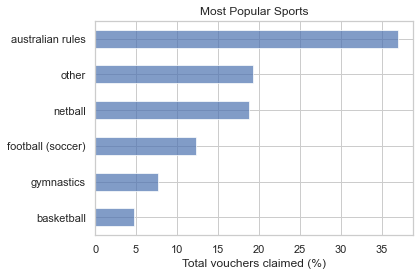

In [35]:
sns.set_theme(style="whitegrid")
fig, axes= plt.subplots(1,1)


sportsClaim['percentage'].sort_values().plot(kind='barh', style='b', alpha=0.7,
              title='Most Popular Sports')

plt.xlabel('Total vouchers claimed (%)')

plt.tight_layout()
plt.show()

We can see Australian Rules and Netball are the most popular. Netball nearly having the same claim proportion as all the other sports combined. We expect this as we know most South Australians play these popular sports growing up. Other factors that can be included may be the regions in which these sports are played. Some LGAs may have a higher voucher claim rate for a less popular sport than others. We were able to show the most popular sports across all LGAs, though there may be some LGAs where these top sports are not popular. 

Checking the proportion of vouchers claimed in the top LGAs:

## Normalising in each LGA

In [36]:
lgaClaim = saSports.sum(axis=1).to_frame(name='sum')

In [37]:
lgaClaim['population'] = LGA_scores['population']

In [38]:
NANpopulation = list(lgaClaim[lgaClaim['population'].isna()].index)

We can drop the NANpopulation from the DF because it is only a small number of vouchers (approx. 600) compared to the total vouchers (approx. 130000). We want to drop the NANpopulation because these represent LGAs that were originally in the sa_vouchers DF but not in the seifa DF. This will cause an issue later on if we don't drop them. 

Dropping NANpopulation should not have an adverse effect on the rest of the data.  

In [39]:
lgaClaim = lgaClaim.drop(NANpopulation)

Normalising the total claims per LGA by the population of the LGA.

In [40]:
lgaClaim['proportion'] = lgaClaim['sum']/ lgaClaim['population']

In [41]:
lgaClaim.head()

,sum,population,proportion
participant_lga,,,
adelaide,302.0,19606.0,0.015403
adelaide hills,4756.0,38601.0,0.123209
alexandrina,2979.0,23693.0,0.125733
barossa,2874.0,22174.0,0.129611
barunga west,333.0,2467.0,0.134982


In [42]:
lgaClaim.nlargest(5, columns='proportion')

,sum,population,proportion
participant_lga,,,
karoonda east murray,388.0,1035.0,0.374879
kimba,232.0,1087.0,0.213431
wudinna,267.0,1256.0,0.212580
cleve,329.0,1729.0,0.190283
southern mallee,342.0,2097.0,0.163090


Storing these LGAs in a list to access them later. These top LGAs have a high claim rate, but their population is also low. Considering these LGAs have a small population, they are most likey far from cities and rural areas. Could there be a relationship between how far an LGA is from a major city and their claim rate? Possibly the distance from a major city is linked to SEIFA scores? This will be explored to an extent in another question.

In [43]:
topLGAs = list(lgaClaim['proportion'].nlargest(5).index)

In [44]:
lgaClaim['percentage'] = round(lgaClaim['proportion']*100,2)

In [45]:
lgaClaim.head()

,sum,population,proportion,percentage
participant_lga,,,,
adelaide,302.0,19606.0,0.015403,1.54
adelaide hills,4756.0,38601.0,0.123209,12.32
alexandrina,2979.0,23693.0,0.125733,12.57
barossa,2874.0,22174.0,0.129611,12.96
barunga west,333.0,2467.0,0.134982,13.50


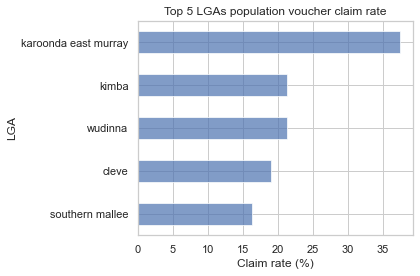

In [46]:
sns.set_theme(style="whitegrid")
fig, axes= plt.subplots(1,1)


ax = lgaClaim.loc[topLGAs]['percentage'].sort_values().plot(kind='barh', style='b', alpha=0.7,
              title='Top 5 LGAs population voucher claim rate')


ax.set(ylabel= 'LGA')

plt.xlabel('Claim rate (%)')

plt.tight_layout()
plt.show()

37.5% of the population in Karoonda east murray has claimed a voucher. The proportion is significantly higher compared to the other `topLGAs`, though it's population is also very small. What could cause a town with a small population to have such a high claim rate? We will explore this in later questions. We saw in the DF `lgaClaim` that this LGA only had a total of 388 vouchers claimed. Below we will see the majority of the claims are in the topSports list. 

In [47]:
saSports.loc['karoonda east murray'].sort_values(ascending=False)[topSports]

voucher_sport
australian rules     169.0
netball              100.0
football (soccer)     18.0
gymnastics            22.0
basketball             7.0
Name: karoonda east murray, dtype: float64

Checking for all the other top LGAs

In [48]:
saSports.loc[topLGAs][topSports].sum(axis=1) / lgaClaim.loc[topLGAs]['sum']

participant_lga
karoonda east murray    0.814433
kimba                   1.000000
wudinna                 0.891386
cleve                   0.860182
southern mallee         0.801170
dtype: float64

What we've shown is that the LGAs with the highest claim rates claim for the most popular sports. The Top LGAs have most of their voucher claims for the top sports. There may potentially be a relationship between the claim rate of an LGA and the type of sports the voucher is used for. Let's check the LGAs with the lowest claim rates

In [49]:
botLGAs = list(lgaClaim['proportion'].nsmallest(5).index)

In [50]:
botLGAs

['kingston', 'adelaide', 'coober pedy', 'peterborough', 'campbelltown']

In [51]:
saSports.loc[botLGAs][topSports].sum(axis=1) / lgaClaim.loc[botLGAs]['sum']

participant_lga
kingston        0.996528
adelaide        0.675497
coober pedy     1.000000
peterborough    0.822222
campbelltown    0.778340
dtype: float64

Again, we checked the proportion of vouchers claimed for the top sports in the bottom LGAs. We've confirmed there is no relationship between the claim rate of an LGA and the type of sports the voucher was used for. This is true because the bottom LGAs have a high claim rate for the top sports. 

## Checking the contributions of proportions per top LGA and 'other' LGAs for Australian Rules

Getting the top 10 LGAs claims and normalising them.

In [52]:
topLGAs2 = list(saSports['australian rules'].nlargest(10).index)

In [53]:
otherSports2DF = saSports['australian rules'].loc[~saSports.index.isin(topLGAs2)].to_frame()

In [54]:
otherSports2DF['proportion'] =(otherSports2DF['australian rules'] / saSports['australian rules'].sum())

In [55]:
aflTop = saSports['australian rules'].loc[topLGAs2].to_frame()

In [56]:
aflTop['proportion'] = aflTop['australian rules'] / saSports['australian rules'].sum()

In [57]:
aflTop = aflTop.T

In [58]:
aflTop['other'] = otherSports2DF.sum()

<Figure size 1080x360 with 0 Axes>

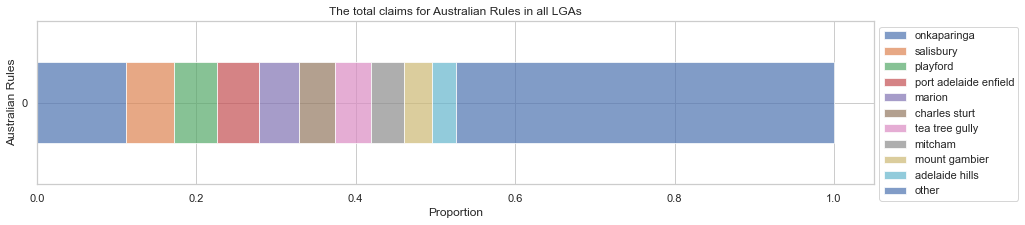

In [59]:
sns.set_theme(style="whitegrid")
# fig = plt.figsize=(12, 5)
plt.figure(figsize=(15,5))

ax = aflTop.drop(index='australian rules').plot(kind = 'barh',stacked=True,style='b', 
                    alpha=0.7,title='The total claims for Australian Rules in all LGAs', figsize=(15,3), use_index=False)


plt.legend(bbox_to_anchor=(1, 1))
ax.set(ylabel='Australian Rules', xlabel = 'Proportion')

plt.show()

Onkaparinga has the highest contribution to the total vouchers claimed for Australian rules. These top 10 LGAs cover nearly half the amount of total vouchers claimed for this sport. The other half represents all other LGAs, totalling 40 additional LGAs. Considering these 10 LGAs, we can explore why they may have the highest contributions using features from the `LGA_scores` (seifa) DF. Though this will be done in later questions.

# Question 2

Are some sports more popular in different parts of the state?

To check what types of sports are popular in different parts of the state: 

- what sports are most popular for each LGA 
- can check the proportion of the top sports in each LGA, this will show how they won't be the same shape. That is aussie rules might be less popular in one compared to gymnastics

### Checking the top 5 LGAs claims of each the top sport, normalised by the LGAs population

Getting the top 5 LGAs for each sport in `topSports` with only the total vouchers claimed. Will do the same for normalised LGAs, that is, getting the top 5 LGAs with the highest claim rates for the top sports.

In [60]:
netball = saSports['netball'].sort_values().nlargest(5)
gymnastics =saSports['gymnastics'].sort_values().nlargest(5)
soccer= saSports['football (soccer)'].sort_values().nlargest(5)
afl= saSports['australian rules'].sort_values().nlargest(5)
basketball = saSports['basketball'].sort_values().nlargest(5)

In [61]:
list1 = list(netball.index.values)
list2 = list(gymnastics.index.values)
list3 = list(soccer.index.values)
list4 = list(afl.index.values)
list5 = list(basketball.index.values)

In [62]:
topSports_topLGAsList = list(set(np.concatenate([list1, list2,list3,list4,list5])))

This Dataframe represents the all LGAs with the most claims in each of the top sports. We want to change these values to their proportions.

In [63]:
topClaims = saSports[topSports].loc[set(topSports_topLGAsList)]
topClaims

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball
participant_lga,,,,,
adelaide hills,1412.0,1395.0,812.0,176.0,48.0
mount barker,1230.0,880.0,333.0,294.0,147.0
charles sturt,2147.0,584.0,917.0,807.0,256.0
port augusta,119.0,765.0,111.0,10.0,364.0
barossa,1196.0,445.0,197.0,117.0,341.0
onkaparinga,5258.0,2242.0,1204.0,1211.0,296.0
tea tree gully,2131.0,1068.0,1356.0,1114.0,284.0
naracoorte lucindale,257.0,165.0,57.0,0.0,364.0
playford,2580.0,904.0,1880.0,451.0,111.0


In [64]:
topClaims['population'] = LGA_scores['population']

In [65]:
topClaims['total'] = saSports.sum(axis=1) / topClaims['population']

In [66]:
topClaims['other'] = saSports.loc[:, ~saSports.columns.isin(topSports)].sum(axis=1).to_frame()

help with `.apply()` from https://appdividend.com/2020/03/05/python-pandas-how-to-apply-formula-to-entire-column-and-row/

Lambda applies a user defined operation to all values (a). So here we are normalising all values with the population of the LGA.

In [67]:
lambdaDF = topClaims.apply(lambda a: a/topClaims['population'] )[topSports]

In [68]:
topClaims[topSports] = lambdaDF[topSports]

In [69]:
topClaims['other'] = topClaims['other'] / topClaims['population']

In [70]:
topClaims.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,population,total,other
participant_lga,,,,,,,,
adelaide hills,0.036579,0.036139,0.021036,0.004559,0.001243,38601.0,0.123209,0.023652
mount barker,0.041267,0.029524,0.011172,0.009864,0.004932,29806.0,0.116386,0.019627
charles sturt,0.020463,0.005566,0.008740,0.007691,0.002440,104922.0,0.065735,0.020835
port augusta,0.008513,0.054729,0.007941,0.000715,0.026041,13978.0,0.108885,0.010946
barossa,0.053937,0.020069,0.008884,0.005276,0.015378,22174.0,0.129611,0.026067


rearranging the order of the columns. Specifically, changng the order of the last three columns. 

In [71]:
columnsList = list(topClaims.columns[:-3])

In [72]:
columnsList.extend(['other','total','population'])

In [73]:
topClaims = topClaims.reindex(columns = columnsList)

Checking to see the total column is correct. Essentially checking the entire process we've done to topClaims was done correctly.

The False value represents the NANs in the DF. We will remove them because they do not exist in the `LGA_scores` DF

In [74]:
round(topClaims[topSports].sum(axis=1) + topClaims['other'], 2) == round(topClaims['total'],2)

participant_lga
adelaide hills            True
mount barker              True
charles sturt             True
port augusta              True
barossa                   True
onkaparinga               True
tea tree gully            True
naracoorte lucindale     False
playford                  True
port adelaide enfield     True
marion                    True
salisbury                 True
whyalla                   True
dtype: bool

In [75]:
topClaims = topClaims.drop(['population'], axis=1)

In [76]:
topClaims = topClaims.dropna()

We can see now therer are no more NAN values

In [77]:
set(round(topClaims[topSports].sum(axis=1) + topClaims['other'], 2) == round(topClaims['total'],2))

{True}

Text(0.5, 1.0, 'Correlation heatmap of the LGAs with the most claims in top sports')

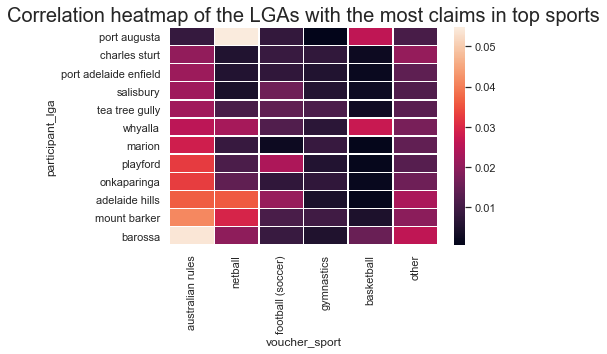

In [78]:
sns.heatmap(data= topClaims.drop(columns='total').sort_values(by= 'australian rules'), linewidths = 0.5)
plt.title('Correlation heatmap of the LGAs with the most claims in top sports', size=20)

We can see that even though the topSports are most popular, there arre still instances when the other sports have quite a high claim rate. Austrralian rules is not popullar in port augusta, but netball and basketball are. We also see that in charles sturt, the other sports are as popular as australan rules. 

A better representation of the above heatmap would be wiith a stacked bar plot. 

In [79]:
topClaims.drop(columns='total').sort_values(by= 'australian rules', ascending = False)

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other
participant_lga,,,,,,
barossa,0.053937,0.020069,0.008884,0.005276,0.015378,0.026067
mount barker,0.041267,0.029524,0.011172,0.009864,0.004932,0.019627
adelaide hills,0.036579,0.036139,0.021036,0.004559,0.001243,0.023652
onkaparinga,0.032962,0.014055,0.007548,0.007592,0.001856,0.016117
playford,0.032624,0.011431,0.023773,0.005703,0.001404,0.012822
marion,0.028456,0.008710,0.002446,0.008662,0.001217,0.014252
whyalla,0.025782,0.023063,0.012143,0.006978,0.027413,0.017354
tea tree gully,0.022323,0.011188,0.014205,0.011670,0.002975,0.013262
salisbury,0.022128,0.004385,0.016030,0.005912,0.002805,0.012033


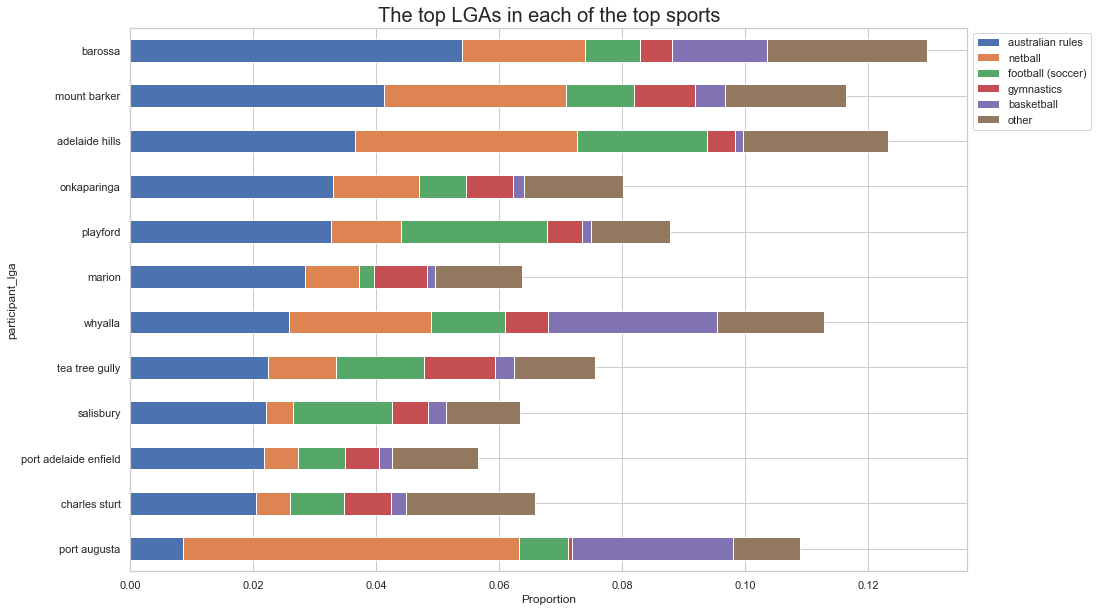

In [80]:
# plt.figure(figsize=(15,10))
plt.rcParams["figure.figsize"] = [15, 10]


ax= topClaims.drop(columns='total').sort_values(by= 'australian rules').plot.barh(stacked=True)
ax.set_xlabel("Proportion")
ax.set_title('The top LGAs in each of the top sports', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

Harder to see some sports, it would be better if this could be from 0 to 1 instead of the max value of the LGAs with the highest claim rates. It would be unwise to plot it like this though because we have normalised with the population of the LGA. So we may have up to 10% of the bar being the claims, but then the remaining 90% would be the population that did not claim. 

Let's check the proportions when we normalise with the LGAs total claims. 

### Checking the top 5 LGAs of each top sport, normalised with the total claims in the LGA.

Repeating nearly the same steps as above, normalising with the total claims instead of population

In [81]:
netball = list((saSports['netball']/ saSports.sum(axis=1)).nlargest(5).index)
gymnastics = list((saSports['gymnastics']/ saSports.sum(axis=1)).nlargest(5).index)
soccer= list((saSports['football (soccer)']/ saSports.sum(axis=1)).nlargest(5).index)
afl= list((saSports['australian rules']/ saSports.sum(axis=1)).nlargest(5).index)
basketball = list((saSports['basketball']/ saSports.sum(axis=1)).nlargest(5).index)

In [82]:
topSports_topLGAsList2 = list(set(np.concatenate([netball, gymnastics,soccer,afl,basketball])))

In [83]:
topClaims = saSports[topSports].loc[set(topSports_topLGAsList2)]

In [84]:
topClaims.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball
participant_lga,,,,,
peterborough,2.0,4.0,24.0,7.0,0.0
coober pedy,39.0,0.0,0.0,0.0,0.0
marion,2362.0,723.0,203.0,719.0,101.0
northern areas,109.0,61.0,228.0,72.0,6.0
whyalla,569.0,509.0,268.0,154.0,605.0


Storing all the sports that are not topSports as 'other' sports

In [85]:
topClaims['other'] = saSports.loc[:, ~saSports.columns.isin(topSports)].sum(axis=1).to_frame()

Determining the total voucher claims of all the sports per LGA.

In [86]:
topClaims['total'] = topClaims.sum(axis=1)

In [87]:
topClaims.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
peterborough,2.0,4.0,24.0,7.0,0.0,8.0,45.0
coober pedy,39.0,0.0,0.0,0.0,0.0,0.0,39.0
marion,2362.0,723.0,203.0,719.0,101.0,1183.0,5291.0
northern areas,109.0,61.0,228.0,72.0,6.0,66.0,542.0
whyalla,569.0,509.0,268.0,154.0,605.0,383.0,2488.0


Normalising the sports

In [88]:
topClaims = topClaims.apply(lambda a: a/topClaims['total'] )

In [89]:
topClaims.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
peterborough,0.044444,0.088889,0.533333,0.155556,0.000000,0.177778,1.0
coober pedy,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
marion,0.446418,0.136647,0.038367,0.135891,0.019089,0.223587,1.0
northern areas,0.201107,0.112546,0.420664,0.132841,0.011070,0.121771,1.0
whyalla,0.228698,0.204582,0.107717,0.061897,0.243167,0.153939,1.0


Text(0.5, 1.0, 'Correlation heatmap of the top LGAs in each of the top sports')

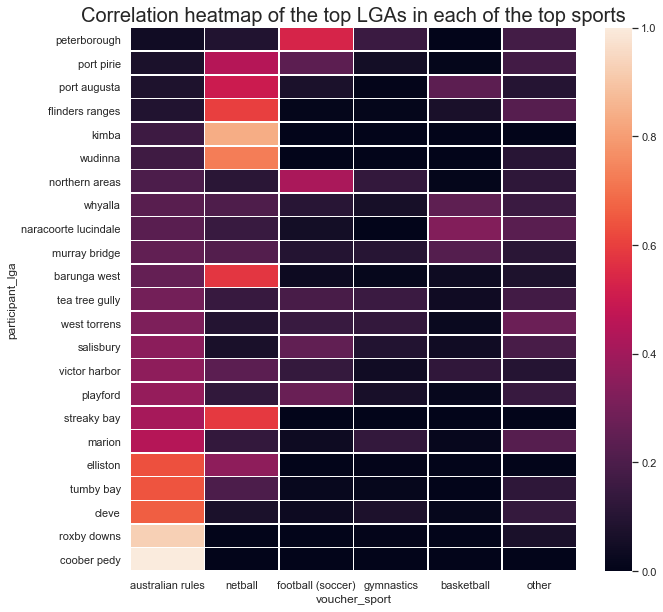

In [90]:
plt.figure(figsize=(10,10))

sns.heatmap(data= topClaims.drop(columns='total').sort_values(by= 'australian rules'), linewidths = 0.5)
plt.title('Correlation heatmap of the top LGAs in each of the top sports', size=20)

We can almost see a pattern that as Australian Rules decreses in popularity over the LGAs, Netball increases. Let's plot this as a stacked bar chart.

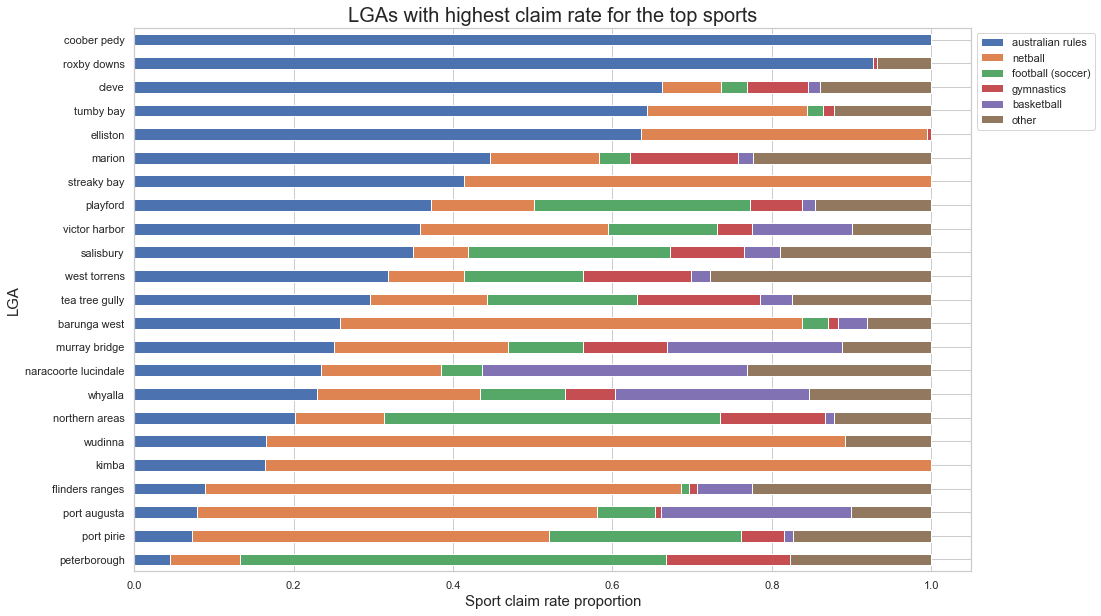

In [91]:
# plt.figure(figsize=(15,10))
plt.rcParams["figure.figsize"] = [15, 10]


topClaims.drop(columns='total').sort_values('australian rules').plot.barh(stacked=True)

plt.legend(bbox_to_anchor=(1, 1))

plt.title('LGAs with highest claim rate for the top sports', size = 20)
plt.xlabel('Sport claim rate proportion', size = 15)
plt.ylabel('LGA', size=15)

plt.show()

Although there is a lot of information in this plot, we can see that as the popularity in one sport decreases, the popularity in another sport increases. We expected this when we first began the process. We can even see that when the two most popular sports decrease in popularity, the other popular sports increase in claim rates. 

Perhaps these LGAs where the top two sports exchange popularity can be a distinction between where they are located in South Australia. I hypothesise that when a sport is popular in one area, surrounding areas will also share the sports popularity. We could illustrate this by plotting a heat map onto the state of South Australia. This will allow us to see where a certain popular sport is located in the state and how the popularity is distributed. Though, this is too advanced for me at the moment as I would have to use something like geopandas. 

Let's make the same plot but for the top LGAs with the highest overall claim rate. Previously we looked at the LGAs with the highets claim rate in each of the top sports. 

### Top 5 LGAs claim rate for top sports 

In [92]:
topClaims5 = saSports[topSports].loc[topLGAs]

In [93]:
topClaims5

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball
participant_lga,,,,,
karoonda east murray,169.0,100.0,18.0,22.0,7.0
kimba,38.0,194.0,0.0,0.0,0.0
wudinna,44.0,194.0,0.0,0.0,0.0
cleve,218.0,24.0,11.0,25.0,5.0
southern mallee,158.0,109.0,1.0,6.0,0.0


In [94]:
topClaims5['other'] = saSports.loc[:, ~saSports.columns.isin(topSports)].sum(axis=1).to_frame()

In [95]:
topClaims5

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other
participant_lga,,,,,,
karoonda east murray,169.0,100.0,18.0,22.0,7.0,72.0
kimba,38.0,194.0,0.0,0.0,0.0,0.0
wudinna,44.0,194.0,0.0,0.0,0.0,29.0
cleve,218.0,24.0,11.0,25.0,5.0,46.0
southern mallee,158.0,109.0,1.0,6.0,0.0,68.0


In [96]:
topClaims5['total'] = topClaims5.sum(axis=1)

In [97]:
topClaims5

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
karoonda east murray,169.0,100.0,18.0,22.0,7.0,72.0,388.0
kimba,38.0,194.0,0.0,0.0,0.0,0.0,232.0
wudinna,44.0,194.0,0.0,0.0,0.0,29.0,267.0
cleve,218.0,24.0,11.0,25.0,5.0,46.0,329.0
southern mallee,158.0,109.0,1.0,6.0,0.0,68.0,342.0


In [98]:
topClaims5 = topClaims5.apply(lambda a: a/topClaims5['total'] )

In [99]:
topClaims5.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
karoonda east murray,0.435567,0.257732,0.046392,0.056701,0.018041,0.185567,1.0
kimba,0.163793,0.836207,0.000000,0.000000,0.000000,0.000000,1.0
wudinna,0.164794,0.726592,0.000000,0.000000,0.000000,0.108614,1.0
cleve,0.662614,0.072948,0.033435,0.075988,0.015198,0.139818,1.0
southern mallee,0.461988,0.318713,0.002924,0.017544,0.000000,0.198830,1.0


Text(0.5, 1.0, 'Correlation heatmap of top 10 LGAs and the top sports')

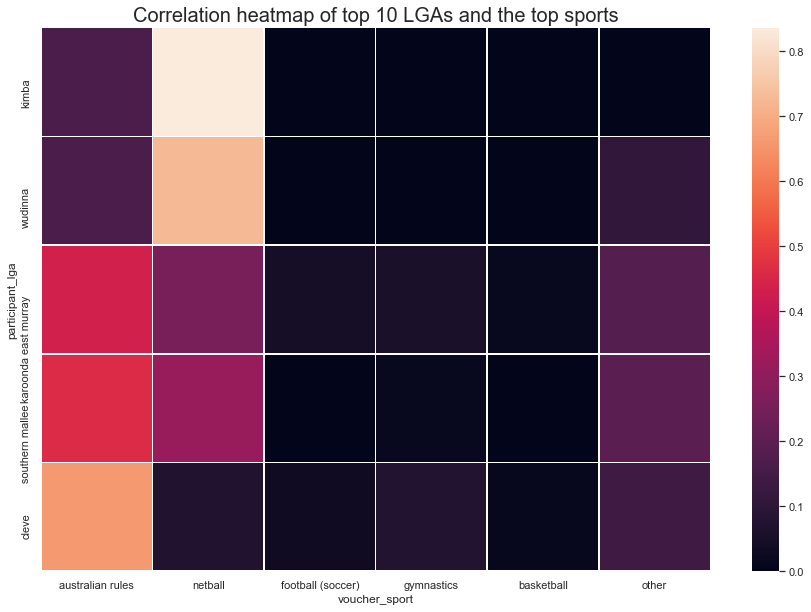

In [100]:
sns.heatmap(data= topClaims5.drop(columns='total').sort_values(by= 'australian rules'), linewidths = 0.5)
plt.title('Correlation heatmap of top 10 LGAs and the top sports', size=20)

In [101]:
topClaims5

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
karoonda east murray,0.435567,0.257732,0.046392,0.056701,0.018041,0.185567,1.0
kimba,0.163793,0.836207,0.000000,0.000000,0.000000,0.000000,1.0
wudinna,0.164794,0.726592,0.000000,0.000000,0.000000,0.108614,1.0
cleve,0.662614,0.072948,0.033435,0.075988,0.015198,0.139818,1.0
southern mallee,0.461988,0.318713,0.002924,0.017544,0.000000,0.198830,1.0


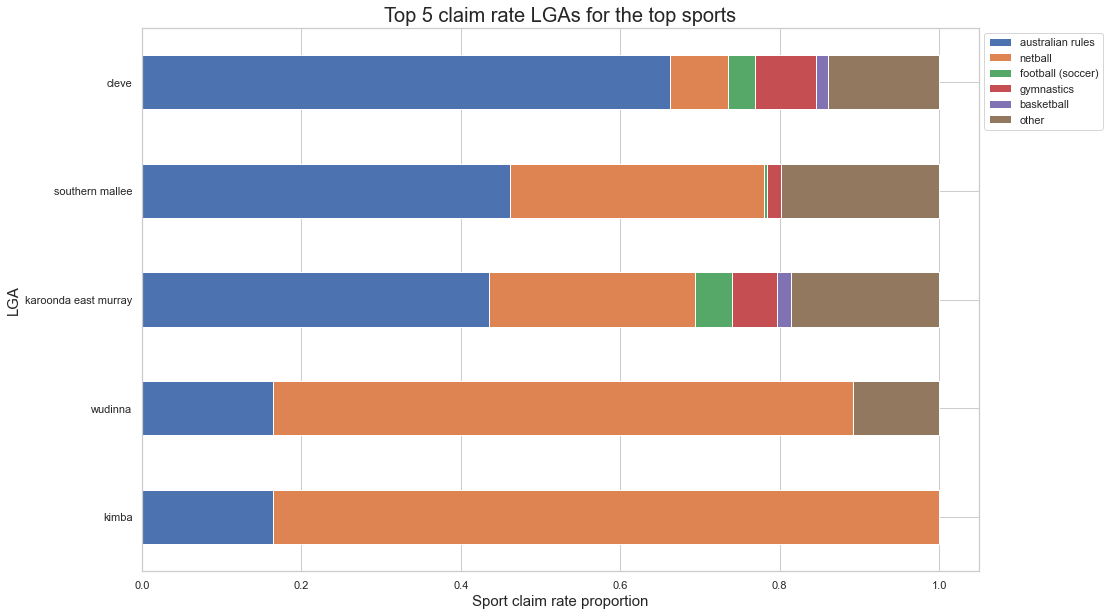

In [102]:
# plt.figure(figsize=(15,10))
plt.rcParams["figure.figsize"] = [15, 10]


topClaims5.drop(columns='total').sort_values(by= 'australian rules').plot.barh(stacked=True)

plt.legend(bbox_to_anchor=(1, 1))

plt.title('Top 5 claim rate LGAs for the top sports', size = 20)
plt.xlabel('Sport claim rate proportion', size = 15)
plt.ylabel('LGA', size=15)

plt.show()

As we saw previously, there is the same pattern as the popularity in one sport decreases, the popularity in the next top sport increases. 

### Top 10 LGAs claim rate for top sports

Doing the same as the previous section but with the top 10 LGAs instead of top 5

In [103]:
lgaClaim.head()

,sum,population,proportion,percentage
participant_lga,,,,
adelaide,302.0,19606.0,0.015403,1.54
adelaide hills,4756.0,38601.0,0.123209,12.32
alexandrina,2979.0,23693.0,0.125733,12.57
barossa,2874.0,22174.0,0.129611,12.96
barunga west,333.0,2467.0,0.134982,13.50


In [104]:
topLGAs10 = list(lgaClaim['proportion'].nlargest(10).index)

In [105]:
topClaims10 = saSports[topSports].loc[topLGAs10]

In [106]:
topClaims10['other'] = saSports.loc[:, ~saSports.columns.isin(topSports)].sum(axis=1).to_frame()

In [107]:
topClaims10['total'] = topClaims10.sum(axis=1)

In [108]:
topClaims10

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
karoonda east murray,169.0,100.0,18.0,22.0,7.0,72.0,388.0
kimba,38.0,194.0,0.0,0.0,0.0,0.0,232.0
wudinna,44.0,194.0,0.0,0.0,0.0,29.0,267.0
cleve,218.0,24.0,11.0,25.0,5.0,46.0,329.0
southern mallee,158.0,109.0,1.0,6.0,0.0,68.0,342.0
tatiara,310.0,454.0,0.0,0.0,122.0,162.0,1048.0
elliston,105.0,59.0,0.0,1.0,0.0,0.0,165.0
orroroo/carrieton,53.0,50.0,0.0,8.0,0.0,26.0,137.0
clare and gilbert valleys,831.0,420.0,8.0,9.0,50.0,31.0,1349.0


In [109]:
topClaims10 = topClaims10.apply(lambda a: a/topClaims10['total'] )

In [110]:
topClaims10.head()

voucher_sport,australian rules,netball,football (soccer),gymnastics,basketball,other,total
participant_lga,,,,,,,
karoonda east murray,0.435567,0.257732,0.046392,0.056701,0.018041,0.185567,1.0
kimba,0.163793,0.836207,0.000000,0.000000,0.000000,0.000000,1.0
wudinna,0.164794,0.726592,0.000000,0.000000,0.000000,0.108614,1.0
cleve,0.662614,0.072948,0.033435,0.075988,0.015198,0.139818,1.0
southern mallee,0.461988,0.318713,0.002924,0.017544,0.000000,0.198830,1.0


Text(0.5, 1.0, 'Correlation heat map of top LGAs and top sports')

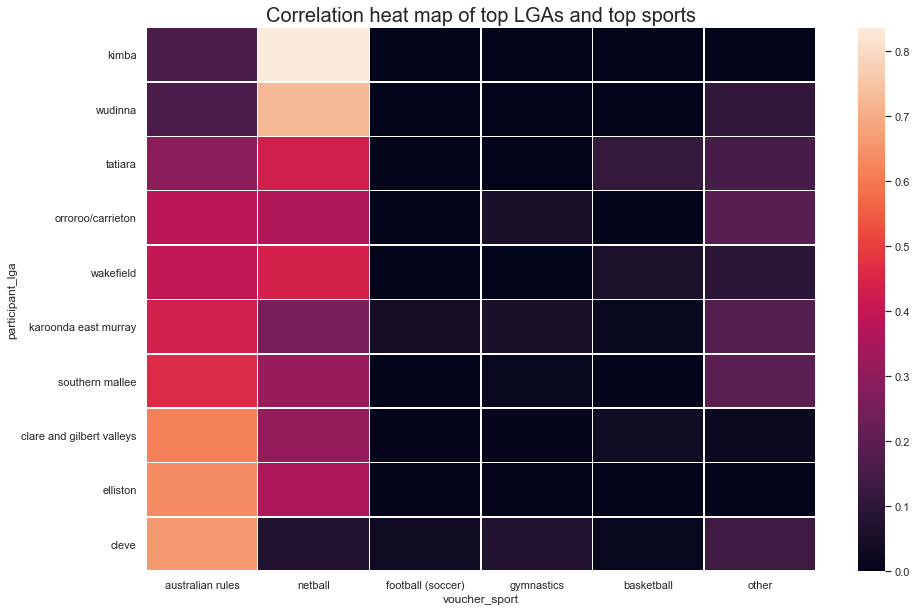

In [111]:
sns.heatmap(data= topClaims10.drop(columns='total').sort_values(by= 'australian rules'), linewidths = 0.5)
# g.fig.suptitle("Your Title", y=1.08) # y= some height>1
plt.title('Correlation heat map of top LGAs and top sports', size=20)

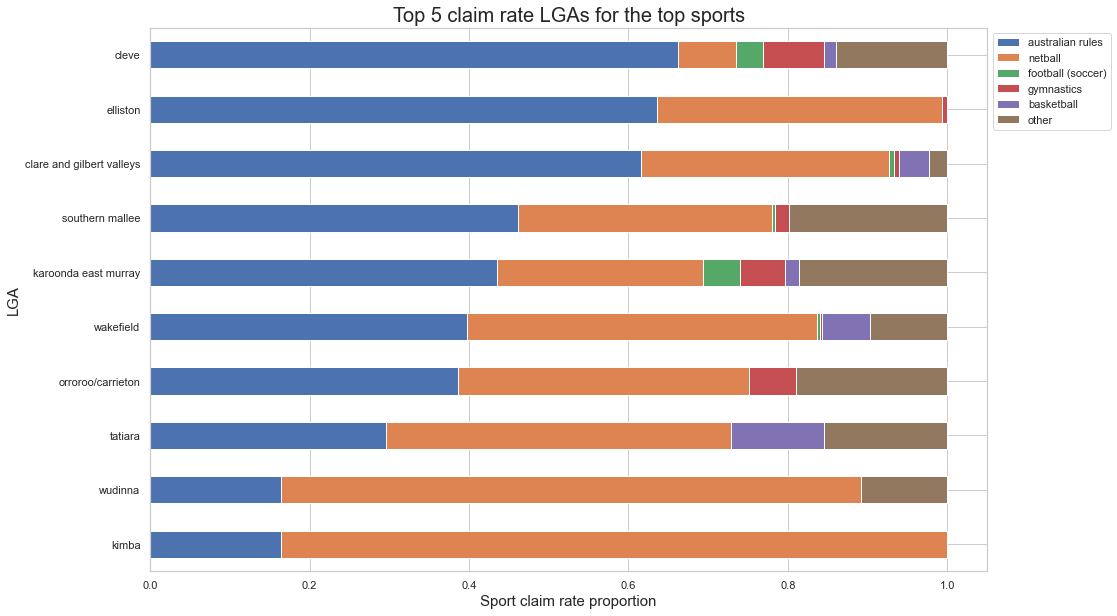

In [112]:
# plt.figure(figsize=(15,10))
plt.rcParams["figure.figsize"] = [15, 10]


topClaims10.drop(columns='total').sort_values(by= 'australian rules').plot.barh(stacked=True)

plt.legend(bbox_to_anchor=(1, 1))

plt.title('Top 5 claim rate LGAs for the top sports', size = 20)
plt.xlabel('Sport claim rate proportion', size = 15)
plt.ylabel('LGA', size=15)

plt.show()

Looks like there is a pattern that as australian rules popularity decreases, netball popularrity increases. 

# Question 3

 Are any LGAs over/under represented in their use of vouchers?

We can determine which LGAs are over and under represented by checking the mean rate. We will assume that the LGAs that are above the mean claim rate are over represented and the LGAs below the mean claim rate are under represented. 

In [113]:
meanClaimRate = lgaClaim['proportion'].sum() / lgaClaim.shape[0]

In [114]:
overRep = lgaClaim[lgaClaim['proportion'] > meanClaimRate]

In [115]:
underRep = lgaClaim[lgaClaim['proportion'] < meanClaimRate]

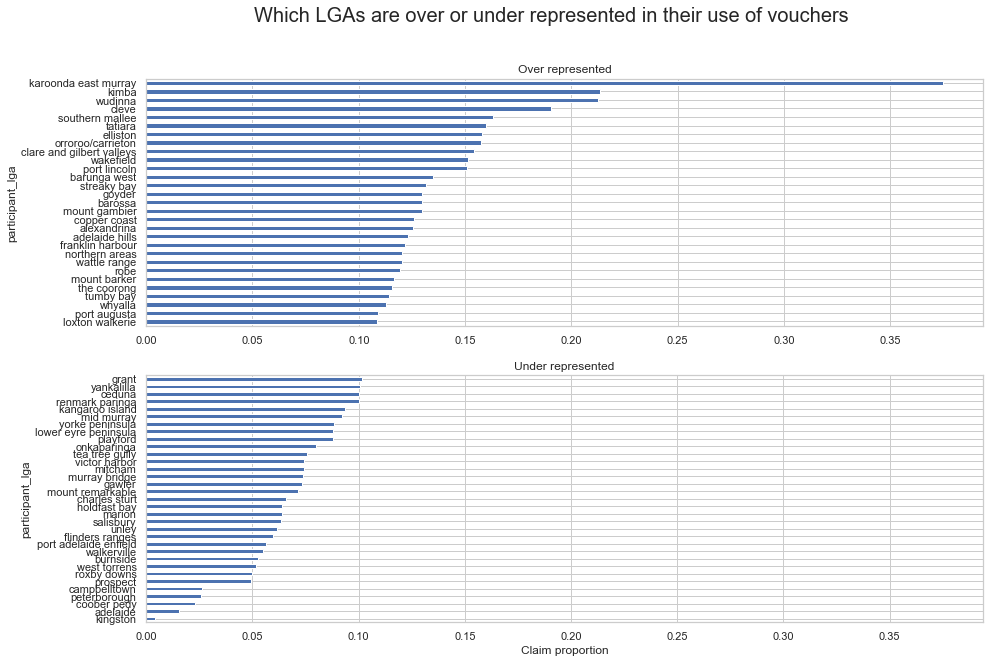

In [116]:
fig, axes = plt.subplots(2,1, figsize=(15,10))

overRep['proportion'].sort_values(ascending=True).plot(kind='barh', ax = axes[0], title='Over represented')
underRep['proportion'].sort_values(ascending=True).plot(kind='barh', ax = axes[1], title='Under represented')

plt.xlabel('Claim proportion')
fig.suptitle('Which LGAs are over or under represented in their use of vouchers', size = 20)
plt.xlim(0,0.394)

plt.show()

Looks like possible outliers being Karoonda East Murray and Kingston. We've visualised how some LGAs have a low and high voucher use. What could the contributing factors be? I believe this is something we would check with the SEIFA scores which is done in a later question. 

# Question 4

 Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

Adding the seifa scores to the sports DF

In [117]:
lgaClaim_scores =lgaClaim

Adding the seifa scores to the DF containing the summary information of the LGAs. Being the sum of the claims in that LGA. 

In [118]:
lgaClaim_scores['ieo'] = LGA_scores['ieo']
lgaClaim_scores['ier'] = LGA_scores['ier']
lgaClaim_scores['irsad'] = LGA_scores['irsad']
lgaClaim_scores['irsd'] = LGA_scores['irsd']

In [119]:
lgaClaim_scores.head()

,sum,population,proportion,percentage,ieo,ier,irsad,irsd
participant_lga,,,,,,,,
adelaide,302.0,19606.0,0.015403,1.54,874.0,874.0,1036.0,1013.0
adelaide hills,4756.0,38601.0,0.123209,12.32,1083.0,1083.0,1077.0,1081.0
alexandrina,2979.0,23693.0,0.125733,12.57,1000.0,1000.0,969.0,987.0
barossa,2874.0,22174.0,0.129611,12.96,1028.0,1028.0,997.0,1017.0
barunga west,333.0,2467.0,0.134982,13.50,981.0,981.0,940.0,954.0


Looking at the top 5 LGAs with the highest and lowest respective scores

In [120]:
lgaClaim_scores.loc[list(lgaClaim_scores['irsad'].nlargest(5).index)]

,sum,population,proportion,percentage,ieo,ier,irsad,irsd
participant_lga,,,,,,,,
burnside,2213.0,42168.0,0.052481,5.25,1044.0,1044.0,1090.0,1081.0
roxby downs,234.0,4694.0,0.049851,4.99,1066.0,1066.0,1086.0,1096.0
adelaide hills,4756.0,38601.0,0.123209,12.32,1083.0,1083.0,1077.0,1081.0
walkerville,386.0,7008.0,0.055080,5.51,1029.0,1029.0,1076.0,1065.0
unley,2266.0,36813.0,0.061554,6.16,1013.0,1013.0,1071.0,1065.0


In [121]:
lgaClaim_scores.loc[list(lgaClaim_scores['irsad'].nsmallest(5).index)]

,sum,population,proportion,percentage,ieo,ier,irsad,irsd
participant_lga,,,,,,,,
peterborough,45.0,1733.0,0.025967,2.60,873.0,873.0,808.0,798.0
playford,6940.0,79082.0,0.087757,8.78,914.0,914.0,868.0,871.0
coober pedy,39.0,1694.0,0.023022,2.30,870.0,870.0,869.0,870.0
murray bridge,1462.0,19742.0,0.074055,7.41,932.0,932.0,887.0,901.0
port augusta,1522.0,13978.0,0.108885,10.89,917.0,917.0,897.0,906.0


When there is more than two columns, it becomes difficult to see if there is a relationship. Let's have a look at a pairplot to quickly see if there is some kind of relationship between the scores and the claims. 

### Relation between vouchers claimed and scores via pairplot

Text(0.5, 1.04, 'Relationship between features')

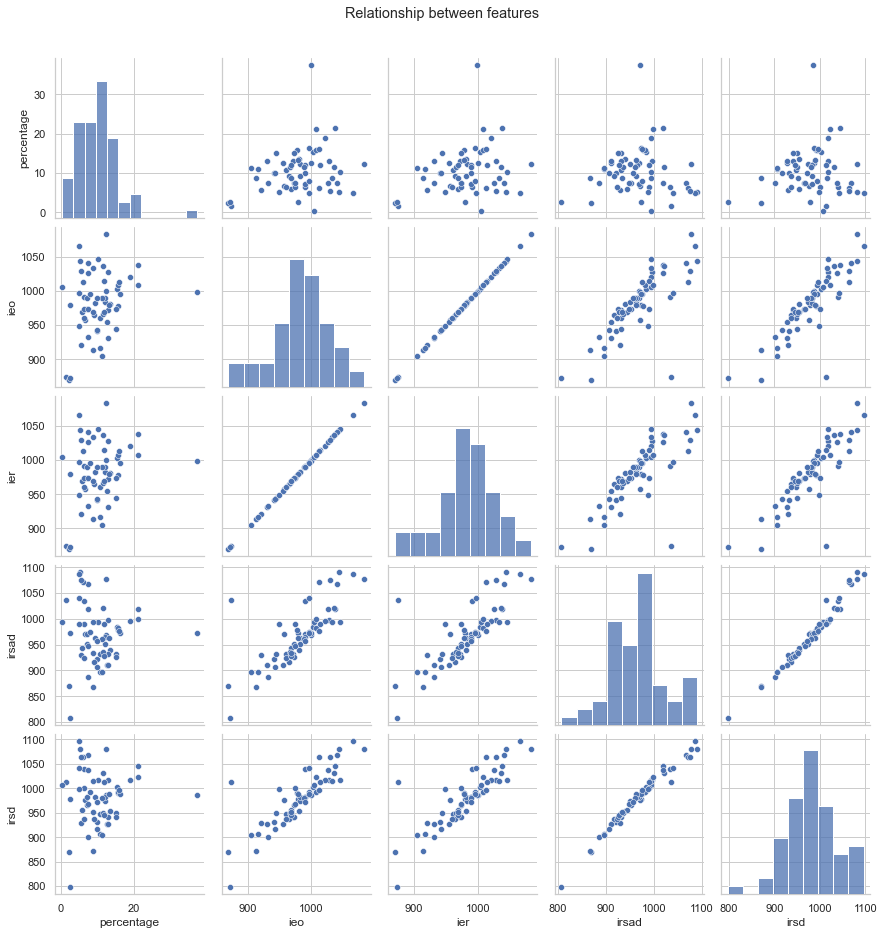

In [122]:
g = sns.pairplot(lgaClaim_scores[list(lgaClaim_scores.columns[-5:])])
g.fig.suptitle("Relationship between features", y=1.04)


Don't really see any relation between claim rate (percentage or proportion) and the scores. We could use a linear regression model to see if there are any relationship between the scores and claim rate. Possibly could even use a logarithmic regression model. 

Checking correlation / heatmap

Dropping the IEO scores because we've noticed IEO = IER. Perhaps there is something wrong with the data because both the scores represent the population differently. One being education and occupation and the other being economic resources. 

In [123]:
set(lgaClaim_scores['ieo'] == lgaClaim_scores['ier'])

{True}

In [124]:
scoresList = list(lgaClaim_scores.columns[-3:])
scoresList.extend(['proportion','sum'])

In [125]:
scoresList

['ier', 'irsad', 'irsd', 'proportion', 'sum']

plotting the correlation matrix as a heatmap to visually see if there are any correlations between the claim rate and the scores

In [126]:
lgaClaim_scores[scoresList].head()

,ier,irsad,irsd,proportion,sum
participant_lga,,,,,
adelaide,874.0,1036.0,1013.0,0.015403,302.0
adelaide hills,1083.0,1077.0,1081.0,0.123209,4756.0
alexandrina,1000.0,969.0,987.0,0.125733,2979.0
barossa,1028.0,997.0,1017.0,0.129611,2874.0
barunga west,981.0,940.0,954.0,0.134982,333.0


Only checking the correlation matrix for the columns inside `scoresList` as we're concerned about whether there is a relationship between the scores and the claim rate (proportion) 

In [127]:
lgaClaim_scores[scoresList].corr()

,ier,irsad,irsd,proportion,sum
ier,1.000000,0.781360,0.848105,0.254972,-0.000399
irsad,0.781360,1.000000,0.985054,-0.026474,0.044818
irsd,0.848105,0.985054,1.000000,0.064524,0.026067
proportion,0.254972,-0.026474,0.064524,1.000000,-0.211298
sum,-0.000399,0.044818,0.026067,-0.211298,1.000000


<AxesSubplot:>

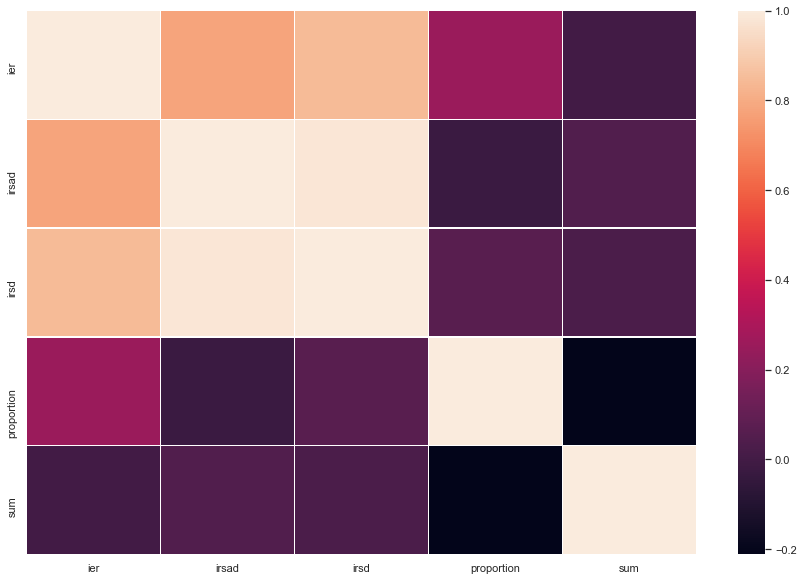

In [128]:
sns.heatmap((lgaClaim_scores[scoresList].corr()), linewidths = 0.5)

checking the proportion row and the scores, we can't really see a relationship. 

Can try to explore it, checking the differences between pearson and spearman correlation. Can also try to use machine learning to find correlation, check correlation matrix. 

Spearman yielded similar results. The difference between the two is Spearman uses the rank of the values rather than the actual values.  

Pearsons and Spearman's correlation:
- measure of skewness.
- Pearson : zero does not necessarily mean the variables are not correlated. 
- Spearman : when the data contains outliers, use spearmans rank correlation. This will use the ranks of the data rather than the actual values. 

### Using LR to find a relationship (for fun / practice) 

Can we use the proportion of claims and SEIFA scores to predict one of said scores? That is input the proportion of claims, and 2/3 of the scores to predict the third score? The scores are closely related in and of itself so perhaps by making this model, knowing the other scores, we can conclude the third score. For example, we know the scores for socioeconomic disadvantages, occupation and education , so can we use these to predict their scores in access to economic resources. 

In [129]:
train, test = train_test_split(lgaClaim_scores, test_size=0.2, random_state=1)
print(train.shape)
print(test.shape)

(49, 8)
(13, 8)


In [130]:
reg = linear_model.LinearRegression()
features = ['proportion','irsad','irsd']
# features = ['proportion']

Xtrain = train[features]
yTrain = train['ier']
reg.fit(Xtrain, yTrain)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [29.34008474 -1.26277095  1.93485128] + 303.68533407448786


In [131]:
predicted = reg.predict(Xtrain)
mse = ((np.array(yTrain)-predicted)**2).sum()/len(yTrain)
r2 = r2_score(yTrain, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 413.00629299396195
R Squared: 0.7952553043026752


In [132]:
Xtest= test[features]
yTest = test['ier']

In [133]:
predicted = reg.predict(Xtest)
mse = ((np.array(yTest)-predicted)**2).sum()/len(yTest)
r2 = r2_score(yTest, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 129.65296449422496
R Squared: 0.9223161512897204


92% of the variance is explained by the model. We expected this to be a high correlation due to the scores being closely related. We've used the features 'proportion', 'irsad', 'irsd' to predict what the 'ier' features would be. From the pairplot, we saw there was a linear relationship between all the scores. Removing the proportion feature would only decrease the R$^2$ value by about 1% meaning it did not have a significant impact on the model. 

We set out to find if there was a relationship between the propotion feature and the scores. Running the model using the proportion feature, we get a $R^2\approx-40$%. Meaning the model fit the data poorly. I did not expect this considering we can nearly see a linear pattern in the pairplot. 

# Challenge Question: Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

### Setting up the DFs

Reading in the CSV file. 

In [134]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [135]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RCS]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

C:\Users\Rudol\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,ieo,ier,irsad,irsd,population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,NaN,NaN,NaN,NaN,NaN
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN


Changing the name of the column and making the strings lower case for ease of referencing. 

In [136]:
qld_vouchers_scores = qld_vouchers_scores.rename(columns = {'Participation Activity':'sport'})

In [137]:
qld_vouchers_scores['sport'] = qld_vouchers_scores['sport'].str.lower()
qld_vouchers_scores['LGA'] = qld_vouchers_scores['LGA'].str.lower()

qld_vouchers_scores.columns  = qld_vouchers_scores.columns.str.lower()

Grouping by the features of interest. 

In [138]:
qldGroup = (qld_vouchers_scores.groupby(['lga','sport']).count()).copy(deep=True)

In [139]:
qldGroup.head()

application number  voucher number  \
lga            sport                                                   
banana         equestrian                          1               1   
               football (soccer)                   1               1   
               netball                             1               1   
blackall tambo athletics                           2               2   
               rugby league                        1               1   

                                  child age (at time of application)  gender  \
lga            sport                                                           
banana         equestrian                                          1       0   
               football (soccer)                                   1       0   
               netball                                             1       0   
blackall tambo athletics                                           2       0   
               rugby league                                        1       0   

                                  has your child played sport before?  \
lga            sport                                                    
banana         equestrian                                           1   
               football (soccer)                                    1   
               netball                                              1   
blackall tambo athletics                                            2   
               rugby league                                         1   

                                  club name  club suburb/town  \
lga            sport                                            
banana         equestrian                 1                 1   
               football (soccer)          1                 1   
               netball                    1                 1   
blackall tambo athletics                  2                 2   
               rugby league               1                 1   

                                  club local government area name  \
lga            sport                                                
banana         equestrian                                       1   
               football (soccer)                                1   
               netball                                          1   
blackall tambo athletics                                        2   
               rugby league                                     1   

                                  club state electoral district  name  \
lga            sport                                                    
banana         equestrian                                           1   
               football (soccer)                                    1   
               netball                                              1   
blackall tambo athletics                                            2   
               rugby league                                         1   

                                  parent suburb/town  total payment  ieo  ier  \
lga            sport                                                            
banana         equestrian                          1              1    0    0   
               football (soccer)                   1              1    0    0   
               netball                             1              1    0    0   
blackall tambo athletics                           2              2    0    0   
               rugby league                        1              1    0    0   

                                  irsad  irsd  population  
lga            sport                                       
banana         equestrian             0     0           0  
               football (soccer)      0     0           0  
               netball                0     0           0  
blackall tambo athletics              0     0           0  
               rugby league           0     0           0

Pivoting for ease of viewing

In [140]:
qldSports = pd.pivot_table(qldGroup, values = 'voucher number', index = 'lga', columns = 'sport')

Filling the NA values as they represent zero. 

In [141]:
qldSports = qldSports.fillna(0)

In [142]:
qldSports.head()

sport,*other,archery,athletics,australian football,baseball,basketball,bmx bicycle motocross,body boarding,bowls lawn,boxing,...,t-ball,table tennis,taekwondo,tennis,tenpin bowling,touch,trail bike riding,trampolining,weightlifting,zen do kai martial arts
lga,,,,,,,,,,,,,,,,,,,,,
banana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blackall tambo,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brisbane,11.0,0.0,1.0,68.0,3.0,78.0,5.0,0.0,0.0,2.0,...,1.0,0.0,5.0,5.0,0.0,0.0,1.0,7.0,0.0,0.0
bundaberg,0.0,0.0,3.0,3.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
burdekin,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Matching the sport names to those in SA

There are a different number of sports in both states

In [143]:
print(f'Number of sports in QLD: {len(qldSports)}')

Number of sports in QLD: 45


In [144]:
print(f'Number of sports in SA: {len(saSports)}')

Number of sports in SA: 69


I want to find out which sports are the same. 

In [145]:
sameSports = [] 

for val in list(qldSports.columns):
    if val in list(saSports.columns):
        sameSports.append(val)

print(f' There are {len(sameSports)} common sports in both states')

 There are 32 common sports in both states


Checking what sports are different in QLD and SA


In [146]:
saSports.columns[~saSports.columns.isin(sameSports)]

Index(['australian rules', 'bmx', 'badminton', 'bowls', 'diving', 'fencing',
       'kung fu (wu shu)', 'lacrosse', 'motor sport', 'motorcycling',
       'orienteering', 'paralympics', 'pony clubs', 'surf lifesaving',
       'surf riding', 'volleyball', 'water polo', 'wrestling'],
      dtype='object', name='voucher_sport')

In [147]:
qldSports.columns[~qldSports.columns.isin(list(set(saSports.columns)))]

Index(['*other', 'australian football', 'bmx bicycle motocross',
       'body boarding', 'bowls lawn', 'boxing', 'broomball', 'bushwalking',
       'canoeing outrigger', 'cheerleading', 'disability sports',
       'dragon boating', 'futsal', 'ice hockey', 'inline hockey', 'karting',
       'kayaking', 'life saving surf', 'mixed martial arts', 'motor cycling',
       'oztag', 'parkour', 'polocrosse', 'pony club',
       'riding for the disabled', 'rock climbing', 'skipping', 'surfing',
       'swimming synchronised', 't-ball', 'tenpin bowling',
       'trail bike riding', 'trampolining', 'zen do kai martial arts'],
      dtype='object', name='sport')

We can see there are a few common sports that still remain but they are spelled differently. We will have to fix those manually. 

Renaming the features that appear in both DFs so that they are the same.

In [148]:
qldSports = qldSports.rename(columns= {'australian football' : 'australian rules', 'bmx bicycle motocross': 'bmx',
                                      'bowls lawn': 'bowls', 'disability sports': 'paralympics', 'motor cycling': 'motorcycling',
                                      'pony club': 'pony clubs', 'surfing':'surf riding'})

Now that we've renamed the columns, can find the similar columns with the loop again. 

In [149]:
sameSports2 = [] 

for val in list(qldSports.columns):
#     print(val)
    if val in list(saSports.columns):
#         print(val)
        sameSports2.append(val)

print(f' There are {len(sameSports2)} common sports in both states')

 There are 39 common sports in both states


now we have the columns with same sports, we want to save those columns in the DF and put the rest of the uncommon sports as 'other'

In [150]:
qld_otherSportsList = qldSports.columns[~qldSports.columns.isin(sameSports2)]

In [151]:
qldSports[qld_otherSportsList].sum(axis=1).to_frame(name='other').head()

,other
lga,
banana,0.0
blackall tambo,0.0
brisbane,173.0
bundaberg,0.0
burdekin,0.0


In [152]:
qldSportsClean = qldSports[sameSports2]

In [153]:
qldSportsClean['other']= qldSports[qld_otherSportsList].sum(axis=1).to_frame()

C:\Users\Rudol\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [154]:
qldSportsClean.head()

sport,archery,athletics,australian rules,baseball,basketball,bmx,bowls,calisthenics,cricket,cycling,...,softball,squash,surf riding,swimming,table tennis,taekwondo,tennis,touch,weightlifting,other
lga,,,,,,,,,,,,,,,,,,,,,
banana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blackall tambo,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brisbane,0.0,1.0,68.0,3.0,78.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,48.0,0.0,5.0,5.0,0.0,0.0,173.0
bundaberg,0.0,3.0,3.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
burdekin,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
len(qldSportsClean.columns)

40

In [156]:
len(saSports.columns)

50

Grouping the sports that are not the same in the SA DF into an 'other' column 

In [157]:
sa_otherSportsList = saSports.columns[~saSports.columns.isin(sameSports2)]

In [158]:
saSportsClean = saSports[sameSports2]

In [159]:
saSportsClean['other']= saSports[sa_otherSportsList].sum(axis=1).to_frame()

C:\Users\Rudol\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [160]:
saSportsClean.head()

voucher_sport,archery,athletics,australian rules,baseball,basketball,bmx,bowls,calisthenics,cricket,cycling,...,softball,squash,surf riding,swimming,table tennis,taekwondo,tennis,touch,weightlifting,other
participant_lga,,,,,,,,,,,,,,,,,,,,,
adelaide,0.0,16.0,130.0,1.0,4.0,0.0,0.0,1.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,11.0,4.0,0.0,0.0,36.0
adelaide hills,3.0,204.0,1412.0,11.0,48.0,2.0,0.0,62.0,128.0,1.0,...,27.0,0.0,0.0,18.0,3.0,44.0,257.0,2.0,0.0,38.0
adelaide plains,0.0,3.0,485.0,3.0,15.0,0.0,0.0,23.0,3.0,2.0,...,6.0,0.0,0.0,3.0,0.0,0.0,13.0,0.0,0.0,5.0
alexandrina,9.0,62.0,980.0,0.0,204.0,4.0,0.0,5.0,8.0,0.0,...,24.0,0.0,2.0,11.0,0.0,0.0,109.0,0.0,0.0,40.0
barossa,0.0,158.0,1196.0,6.0,341.0,3.0,0.0,9.0,56.0,0.0,...,3.0,0.0,0.0,12.0,0.0,0.0,83.0,0.0,0.0,1.0


now there are the exact same sports in both states. We have finished setting up the DFs. 

### Checking the top sports and top LGAs for both states

We know the top sports and LGAs for SA being in `topSports` and `topLGAs`, we need to perform the same process for QLD.

In [161]:
claimDF_qldLGAs = qldSportsClean.sum(axis=1).to_frame(name='sum')

In [162]:
claimDF_qldLGAs['claim proportion'] = claimDF_qldLGAs['sum'] / claimDF_qldLGAs['sum'].sum()

In [163]:
claimDF_qldLGAs['population'] = LGA_scores['population']

In [164]:
claimDF_qldLGAs = claimDF_qldLGAs.dropna()

In [165]:
claimDF_qldLGAs['pop proportion'] = claimDF_qldLGAs['sum'] / claimDF_qldLGAs['population']

In [166]:
claimDF_qldLGAs = claimDF_qldLGAs.sort_values(by='claim proportion')

Checking the claim rates proportions by the population provides too small of figures. We only see claim rates of up to 1.6% of the entire population for that LGA. Storing the least popular sports for QLD and the LGAs with the lower claim rate in proportion to the LGAs total claims.

In [167]:
claimDF_qldSports= qldSportsClean.sum().to_frame(name='sum')
claimDF_qldSports['claim proportion'] = claimDF_qldSports['sum'] / claimDF_qldSports['sum'].sum()

In [168]:
claimDF_qldSports = claimDF_qldSports.sort_values(by='claim proportion')

In [169]:
topSports_qld = list(claimDF_qldSports['claim proportion'].nlargest(5).index)

In [170]:
botSports_qld = list(claimDF_qldSports['claim proportion'].nsmallest(5).index)

In [171]:
topLGAs_qld = list(claimDF_qldLGAs['claim proportion'].nlargest(5).index)

In [172]:
botLGAs_qld = list(claimDF_qldLGAs['claim proportion'].nsmallest(5).index)

### Comparing the topSports_qld and topSports

Modifying the DFs so they can be plotted easily as a stacked bar plot. They will contain the top sports in each state and the 'other' sports. The DF will distinguish between the states by adding another column 'state'.

In [173]:
claimDF = claimDF.rename(columns={'proportion':'claim proportion'})

In [174]:
sportClaim_qldSports = claimDF_qldSports.loc[topSports_qld]

In [175]:
sportClaim_qldSports['qld']=sportClaim_qldSports['claim proportion']

In [176]:
sportClaim_qldSports = sportClaim_qldSports.drop(columns=['sum','claim proportion'])

In [177]:
sportClaim_qldSports['sa']= claimDF.loc[topSports_qld]['claim proportion']

In [178]:
sportClaim_saSports = claimDF_qldSports.loc[topSports]

In [179]:
sportClaim_saSports['qld'] = sportClaim_saSports['claim proportion']

In [180]:
sportClaim_saSports = sportClaim_saSports.drop(columns=['sum','claim proportion'])

In [181]:
sportClaim_saSports['sa']= claimDF.loc[topSports]['claim proportion']

In [182]:
sportClaim_saSports=sportClaim_saSports.T

In [183]:
sportClaim_saSports.head()

sport,australian rules,netball,football (soccer),gymnastics,basketball
qld,0.057642,0.132849,0.218155,0.056695,0.039550
sa,0.370309,0.188330,0.123700,0.077027,0.047175


Using code from a previous question to get the ratio of all the 'other' sports. It would have been better to have this stored as it's own variable, considering how few we use specific sports listed in 'other'

In [184]:
saOthersports_qld = qldSportsClean.loc[:, ~qldSportsClean.columns.isin(topSports)].sum(axis=1).to_frame().sum()[0]/claimDF_qldSports['sum'].sum() 
saOthersports_sa = otherSportsDF['proportion'][0]

In [185]:
sportClaim_saSports['other'] = [saOthersports_qld ,saOthersports_sa]

Doing the same for the qld top sports

In [186]:
sportClaim_qldSports=sportClaim_qldSports.T

In [187]:
qldOthersports_qld = qldSportsClean.loc[:, ~qldSportsClean.columns.isin(topSports_qld)].sum(axis=1).to_frame().sum()[0]/claimDF_qldSports['sum'].sum()
qldOthersports_sa = saSportsClean.loc[:, ~saSportsClean.columns.isin(topSports_qld)].sum(axis=1).to_frame().sum()[0]/claimDF['sum'].sum()

In [188]:
sportClaim_qldSports['other'] = [qldOthersports_qld,  qldOthersports_sa]

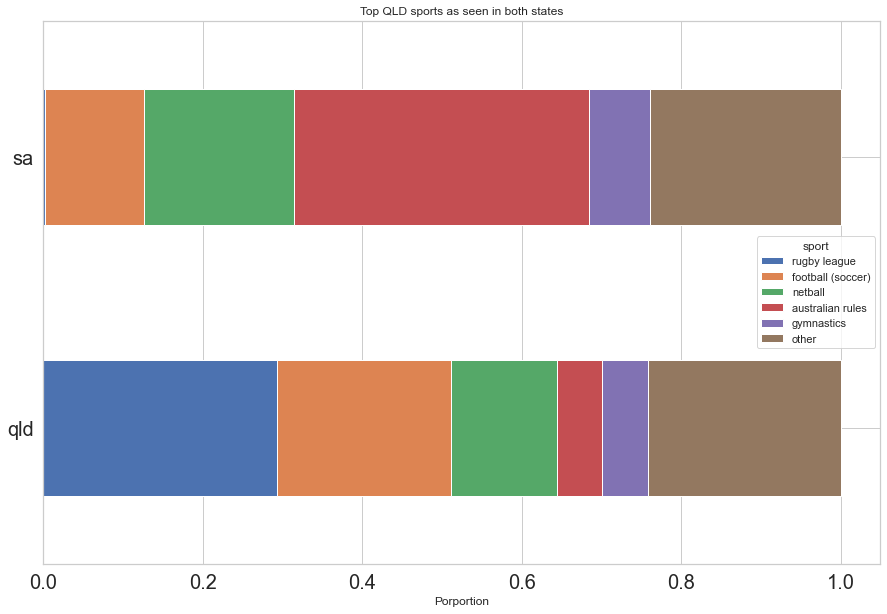

In [189]:
ax1= sportClaim_qldSports.plot(kind='barh',stacked= True, title='Top QLD sports as seen in both states', fontsize= 20)
plt.xlabel('Porportion')
plt.show()

Rugby league is the most popular sport in QLD but in SA, it hardly displays on the plot. On the other hand, the most popular sport in SA is Australian Rules, though still significant in QLD. The other top sports in QLD have a similar claim rate in QLD and SA. 

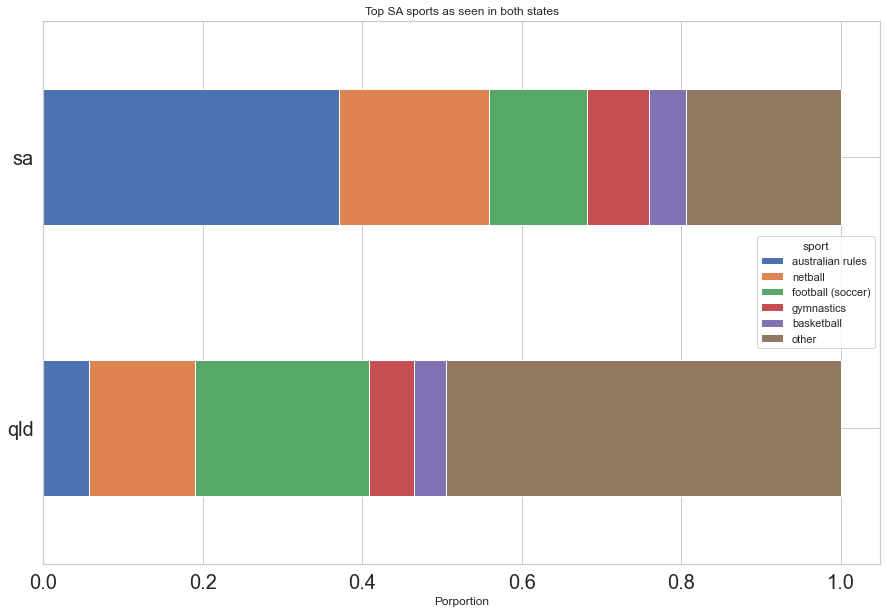

In [190]:
ax2 = sportClaim_saSports.plot(kind='barh',stacked= True, title='Top SA sports as seen in both states', fontsize= 20)
plt.xlabel('Porportion')

plt.show()

Checking the top sports of SA, a significant portion of the claim rate in QLD is attributed to other sports. Mainly due to the fact that Rugby league is included in other sports when we consider the top sports of SA.

In conclusion, we can see that the top sports in both states are quite similar, except the most popular sport in QLD is Rugby League compared to SA's Australian Rules. Rugby league is not popular in SA at all, possibly due to cultural differences between the states. The top sports of QLD in SA and QLD have a similar total claim rate of ~75%. The top sports of SA in QLD and SA has a significantly different total claim rate, ~50% and ~80% respectively.

We should also check how the top LGAs in both states compare. 

### How do the claim rates in the top LGAs compare in both states?

In [191]:
claimDF_qldLGAs.loc[topLGAs_qld]

,sum,claim proportion,population,pop proportion
lga,,,,
gold coast,1700.0,0.178816,494591.0,0.003437
brisbane,1425.0,0.149890,1042074.0,0.001367
sunshine coast,974.0,0.102451,306889.0,0.003174
moreton bay,938.0,0.098664,377992.0,0.002482
logan,805.0,0.084674,278080.0,0.002895


In [192]:
lgaClaim_saTop = lgaClaim.loc[topLGAs].drop(columns = 'percentage').rename(columns = {'proportion': 'claim proportion'})

In [193]:
lgaClaim_qldTop = claimDF_qldLGAs.loc[topLGAs_qld].drop(columns='pop proportion')

In [194]:
lgaClaim_saTop = lgaClaim_saTop[['sum','claim proportion','population']]

In [195]:
lgaClaim_saTop['state'] = 'sa'

In [196]:
lgaClaim_qldTop['state']= 'qld'

In [197]:
lgaClaim_top = lgaClaim_saTop.append(lgaClaim_qldTop)

In [198]:
lgaClaim_top

,sum,claim proportion,population,state
karoonda east murray,388.0,0.374879,1035.0,sa
kimba,232.0,0.213431,1087.0,sa
wudinna,267.0,0.212580,1256.0,sa
cleve,329.0,0.190283,1729.0,sa
southern mallee,342.0,0.163090,2097.0,sa
gold coast,1700.0,0.178816,494591.0,qld
brisbane,1425.0,0.149890,1042074.0,qld
sunshine coast,974.0,0.102451,306889.0,qld
moreton bay,938.0,0.098664,377992.0,qld
logan,805.0,0.084674,278080.0,qld


In [199]:
list(lgaClaim_top.index)

['karoonda east murray',
 'kimba',
 'wudinna',
 'cleve',
 'southern mallee',
 'gold coast',
 'brisbane',
 'sunshine coast',
 'moreton bay',
 'logan']

Text(28.54260694444443, 0.5, 'LGA')

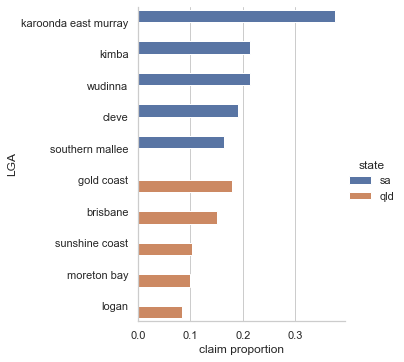

In [200]:
sns.catplot(data = lgaClaim_top, x = 'claim proportion', kind = 'bar', y= list(lgaClaim_top.index) , hue = 'state')

plt.ylabel('LGA')


Almost all of the top LGAs in SA have a higher claim rate than QLD. Indicating SA must have a higher overall claim rate. Perhaps this is due to the difference in SEIFA scores. We saw previously what the scores were for SA and concluded there was no relationship betwen the scores and the claim rate. We should also check for QLD. SA also has a larger dataset compared to QLD. 

### Checking if there is a relationship with the seifa scores and claims 

In [201]:
lgaList_qld = list(qldSports.index)

Checking if all of the LGAs in QLD are in the SEIFA scores DF. 

In [202]:
set(lgaList_qld).issubset(set(LGA_scores.index))

False

The following LGAs do not exist in `LGA_scores`: 

In [203]:
set(lgaList_qld)- set(LGA_scores.index)

{'douglas', 'hervey bay', 'livingstone', 'mareeba', 'noosa'}

Removing them from the DF

In [207]:
removeList = list(set(lgaList_qld)- set(LGA_scores.index))

In [208]:
lgaList_qld = list(set(lgaList_qld) - set(removeList))

In [209]:
qldScores = LGA_scores.loc[lgaList_qld]

In [210]:
qldScores['claim total'] = qldSportsClean.sum(axis=1)

In [211]:
qldScores.head()

INDEX_TYPE,ieo,ier,irsad,irsd,population,claim total
LGA,,,,,,
isaac,1036.0,1036.0,1028.0,1047.0,22568.0,1.0
south burnett,960.0,960.0,914.0,924.0,31006.0,107.0
whitsunday,989.0,989.0,966.0,982.0,31393.0,18.0
north burnett,958.0,958.0,917.0,928.0,10128.0,6.0
banana,1017.0,1017.0,980.0,997.0,14451.0,3.0


In [212]:
qldScores['population proportion'] = qldScores['claim total'] / qldScores['population']

In [213]:
qldScores['claim proportion'] = qldScores['claim total'] / qldSportsClean.sum(axis=0).sum()

In [214]:
qldScores.head()

INDEX_TYPE,ieo,ier,irsad,irsd,population,claim total,population proportion,claim proportion
LGA,,,,,,,,
isaac,1036.0,1036.0,1028.0,1047.0,22568.0,1.0,0.000044,0.000105
south burnett,960.0,960.0,914.0,924.0,31006.0,107.0,0.003451,0.011255
whitsunday,989.0,989.0,966.0,982.0,31393.0,18.0,0.000573,0.001893
north burnett,958.0,958.0,917.0,928.0,10128.0,6.0,0.000592,0.000631
banana,1017.0,1017.0,980.0,997.0,14451.0,3.0,0.000208,0.000316


Checking if ieo and ier scores are the same again, as they were the same in SA.

In [216]:
set(qldScores['ieo'] == qldScores['ier'])

{True}

In [217]:
corrList = ['ieo','ier','irsad','irsd','population proportion','claim proportion']

In [218]:
qldScores[corrList].corr()

INDEX_TYPE,ieo,ier,irsad,irsd,population proportion,claim proportion
INDEX_TYPE,,,,,,
ieo,1.000000,1.000000,0.854467,0.870619,0.002174,0.260639
ier,1.000000,1.000000,0.854467,0.870619,0.002174,0.260639
irsad,0.854467,0.854467,1.000000,0.984160,-0.004890,0.490042
irsd,0.870619,0.870619,0.984160,1.000000,0.022693,0.385405
population proportion,0.002174,0.002174,-0.004890,0.022693,1.000000,0.062387
claim proportion,0.260639,0.260639,0.490042,0.385405,0.062387,1.000000


<AxesSubplot:xlabel='INDEX_TYPE', ylabel='INDEX_TYPE'>

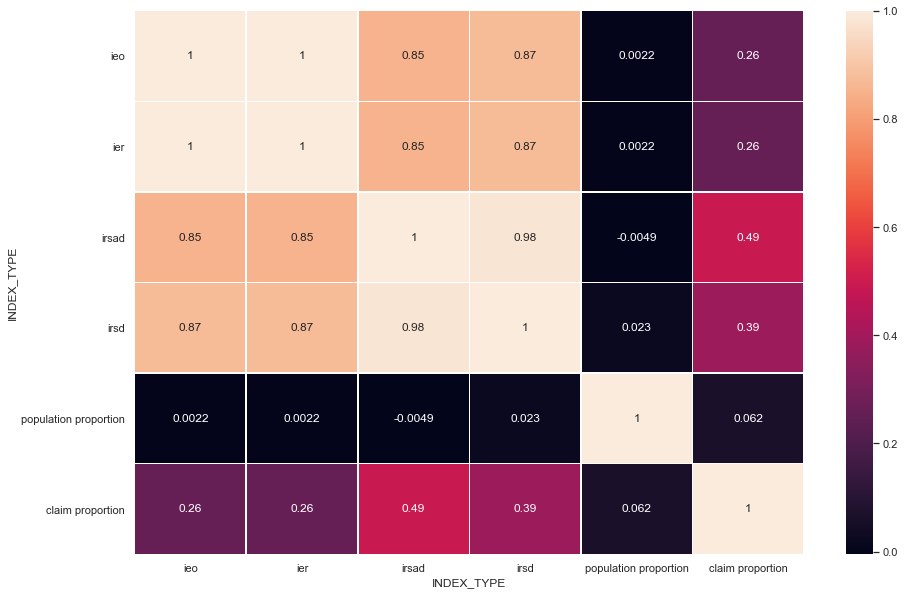

In [219]:
sns.heatmap((qldScores[corrList].corr()), linewidths = 0.5, annot=True)

For each LGA in QLD, the total claims of the LGA normalised by the total claims of QLD has a correlation of 0.49 with the IRSAD scores. 

Total claims normalised by the LGAs population has no correlation with the SEIFA scores. 

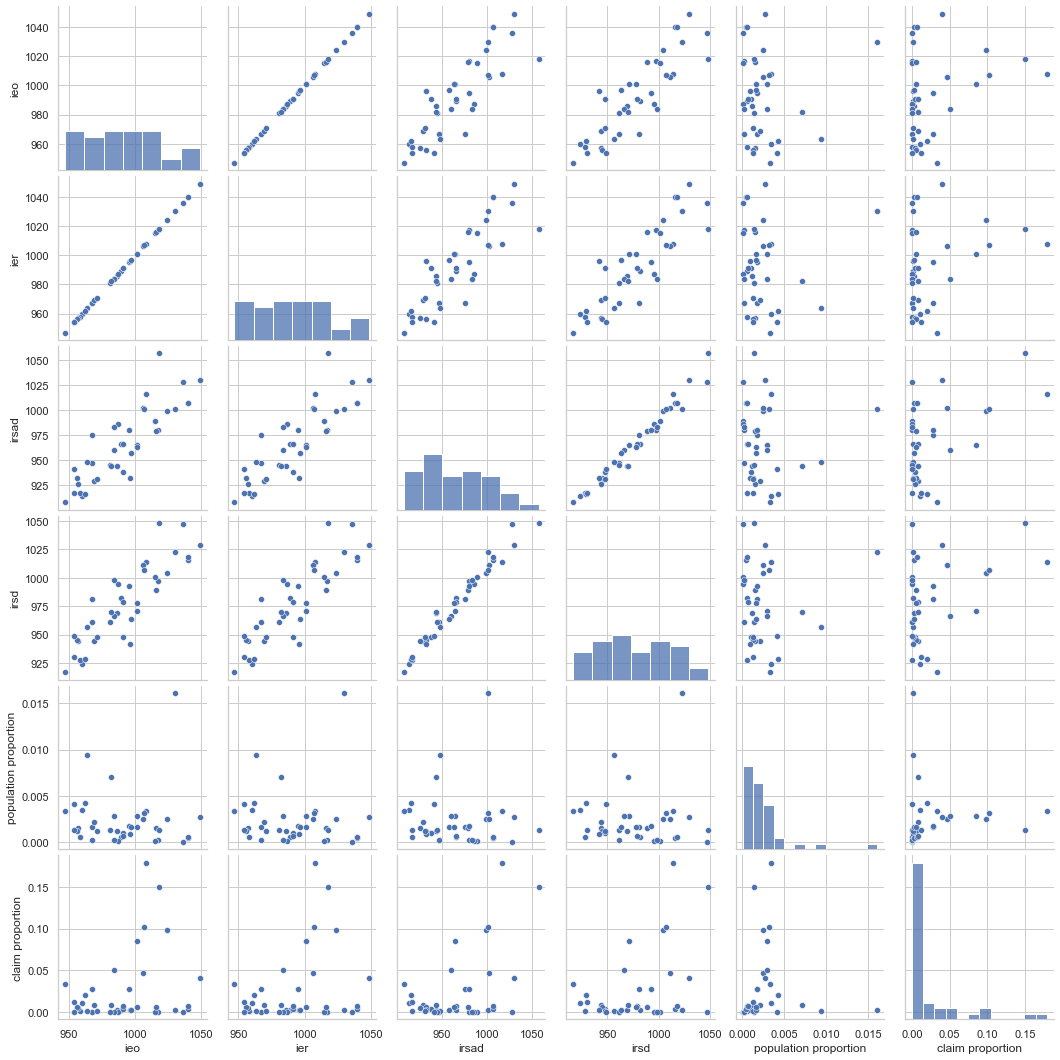

In [220]:
sns.pairplot(qldScores[corrList])

As we've seen previously, there is a linear relationship between the scores themslves. We might be able to fit a linear regression model for the scores and claim proportion which we have also seen previously. We can almost see a linear relationship though there would be a lot of variance in the data points and the model. The model R2 would provide a proportion of the variance explained by the model. We can see more of a relationship compared to the SA scores. 

---

# END OF PF3